In [1]:
%cd "F:\University\Master's Thesis\Datasets\rnd"

F:\University\Master's Thesis\Datasets\rnd


In [4]:
%pip install darts

     ---------------------------------------- 0.0/48.3 kB ? eta -:--:--
     ---------------------------------------- 48.3/48.3 kB 2.5 MB/s eta 0:00:00
     ---------------------------------------- 0.0/160.5 kB ? eta -:--:--
     ------------------------------------- 160.5/160.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/44.0 kB ? eta -:--:--
     ---------------------------------------- 44.0/44.0 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/154.7 kB ? eta -:--:--
     -------------------------------------- 154.7/154.7 kB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/144.2 kB ? eta -:--:--
     -------------------------------------- 144.2/144.2 kB 8.4 MB/s eta 0:00:00
     ----------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import torch
import numpy as np
import pandas as pd
import shutil

from darts import TimeSeries
from darts.models import NHiTSModel, TiDEModel, TFTModel, TCNModel, RNNModel
from darts.datasets import AusBeerDataset
from darts.dataprocessing.transformers.scaler import Scaler
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from darts.metrics import mae, mse

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [3]:
import copy
from pathlib import Path

# List of columns you want to read
selected_columns = ["Timestamp [s]", "CPU usage [%]", "Memory usage [%]"]

file_path = 'VM001.csv'
df = pd.read_csv(file_path, usecols=selected_columns)
df.head(-1)

,Timestamp [s],CPU usage [%],Memory usage [%]
0,2013-06-30 22:03:00,0.000000,6.500000
1,2013-06-30 22:04:00,0.066578,6.536489
2,2013-06-30 22:05:00,0.157880,6.586528
3,2013-06-30 22:06:00,0.220217,6.620693
4,2013-06-30 22:07:00,0.259892,6.642437
...,...,...,...
239030,2013-12-13 21:53:00,5.958158,11.280959
239031,2013-12-13 21:54:00,6.337063,11.567609
239032,2013-12-13 21:55:00,7.714891,12.674611
239033,2013-12-13 21:56:00,10.173214,14.600788


In [4]:
# Convert 'Timestamp [ms]' to datetime and set it as the index
df.set_index('Timestamp [s]', inplace=True)

# Specify the frequency of your time series (e.g., 'H' for hourly, 'D' for daily)
frequency = 'm'  # Replace 'your_frequency' with the appropriate frequency code

# Preserve the 'Timestamp [ms]' column
df['Timestamp [s]'] = df.index

In [5]:
df.head()

,CPU usage [%],Memory usage [%],Timestamp [s]
Timestamp [s],,,
2013-06-30 22:03:00,0.000000,6.500000,2013-06-30 22:03:00
2013-06-30 22:04:00,0.066578,6.536489,2013-06-30 22:04:00
2013-06-30 22:05:00,0.157880,6.586528,2013-06-30 22:05:00
2013-06-30 22:06:00,0.220217,6.620693,2013-06-30 22:06:00
2013-06-30 22:07:00,0.259892,6.642437,2013-06-30 22:07:00


In [6]:
# Create a Darts TimeSeries object
series = TimeSeries.from_dataframe(df, "Timestamp [s]", 'CPU usage [%]')

<Axes: xlabel='Timestamp [s]'>

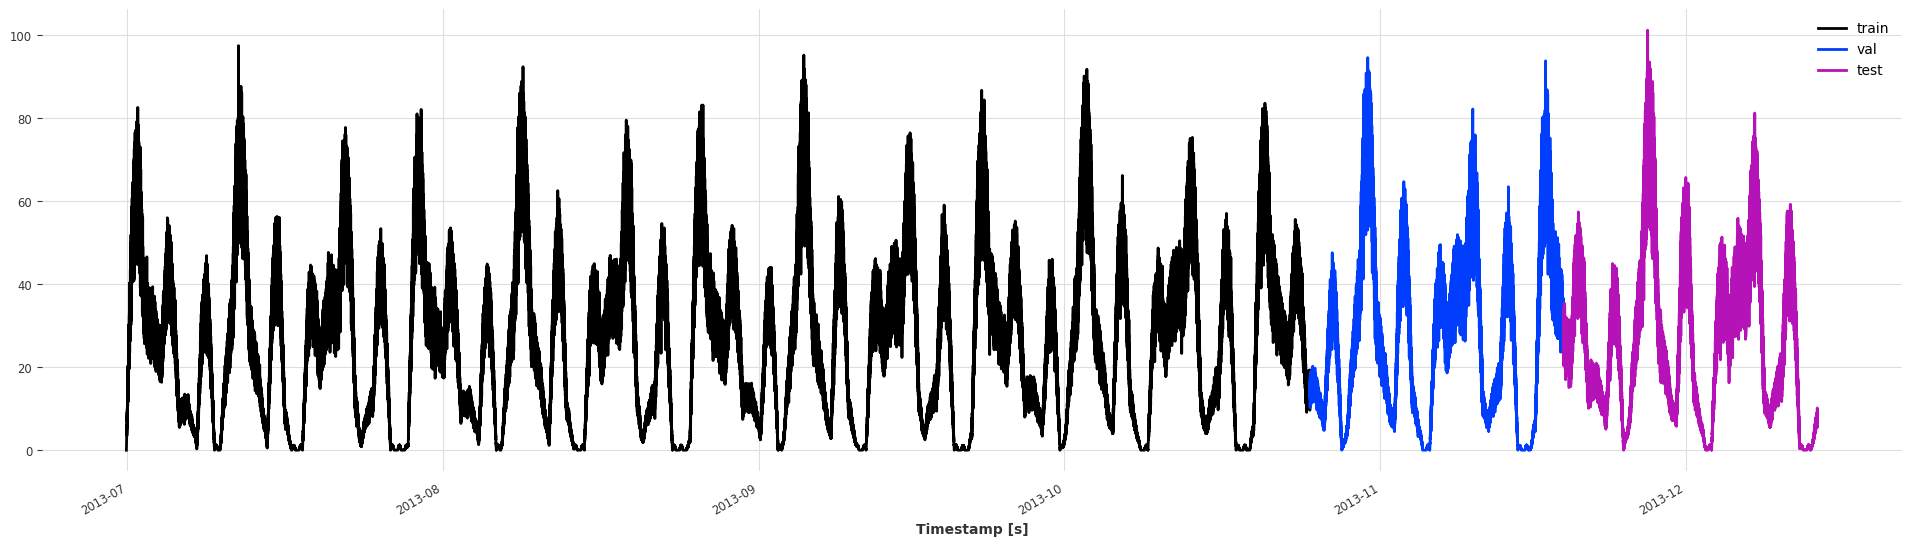

In [7]:
train, temp = series.split_after(0.7)
val, test = temp.split_after(0.5)

plt.figure(figsize=(24, 6))
train.plot(label="train")
val.plot(label="val")
test.plot(label="test")

<Axes: xlabel='Timestamp [s]'>

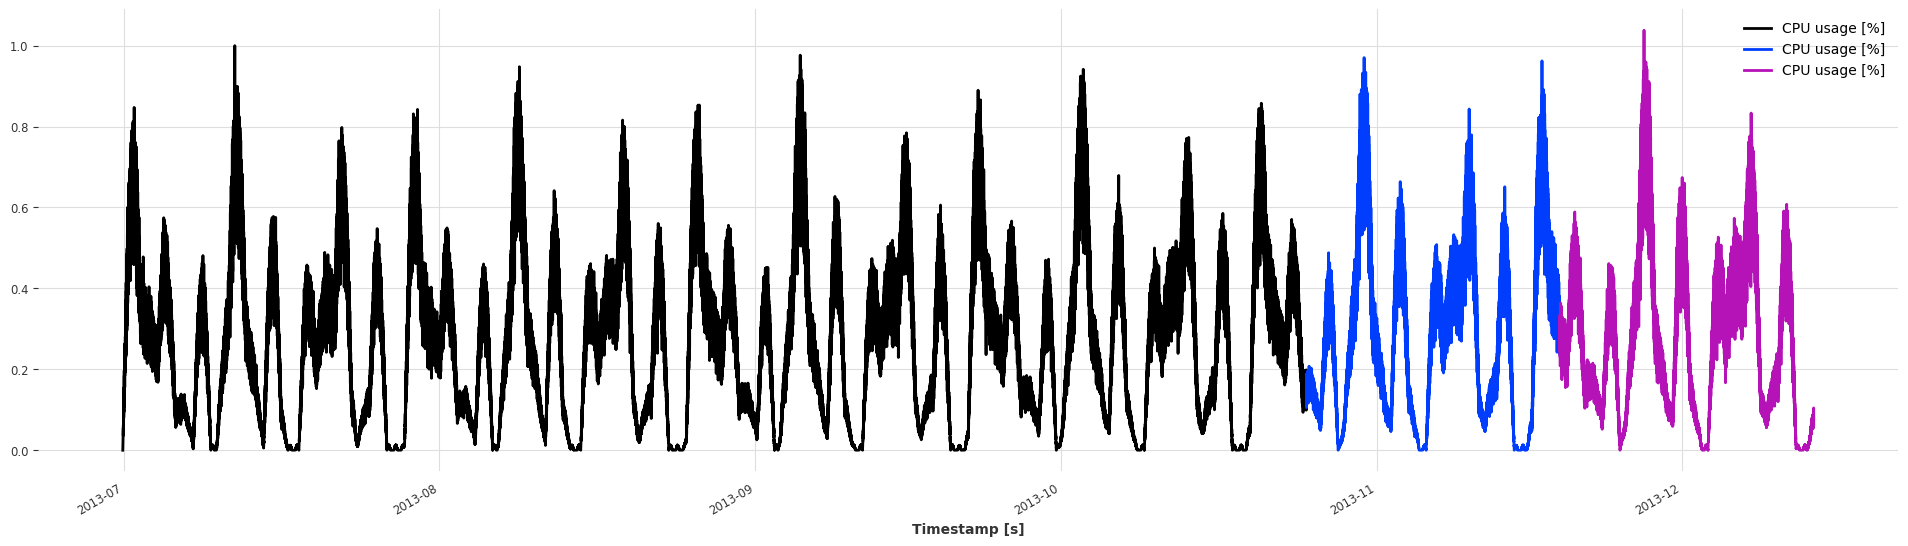

In [8]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

scaler = Scaler()  # default uses sklearn's MinMaxScaler
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

plt.figure(figsize=(24, 6))
train.plot()
val.plot()
test.plot()

In [13]:
# Common parameters
common_model_args = {
    "input_chunk_length": 4320,
    "output_chunk_length": 2880,
    "optimizer_kwargs": {"lr": 1e-3},
    "pl_trainer_kwargs": {
        "gradient_clip_val": 1,
        "max_epochs": 20,
        "accelerator": "auto",
        "callbacks": [],
        "logger": None
    },
    "lr_scheduler_cls": torch.optim.lr_scheduler.ExponentialLR,
    "lr_scheduler_kwargs": {"gamma": 0.999},
    "likelihood": None,
    "save_checkpoints": True,
    "force_reset": True,
    "batch_size": 128,
    "random_state": 42,
}

# Define early stopping arguments
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 3,
    "mode": "min",
    "strict": True,
    "verbose": True,
}

# Update your pl_trainer_kwargs
pl_trainer_kwargs = common_model_args["pl_trainer_kwargs"]


# Model-specific parameters
model_nhits_params = {
    "model_name": "nhits_cpu",
}

model_tide_params = {
    "model_name": "tide_cpu",
    "use_reversible_instance_norm": False,
}

model_tft_params = {
    "model_name": "tft_cpu",
    "add_relative_index": True,
    "hidden_size": 128
}

model_tcn_params = {
    "model_name": "tcn_cpu",
}

model_deepar_params = {
    "model_name": "deepar_cpu",
    "hidden_dim": 20,
    "n_rnn_layers": 2,
    "dropout": 0.2,
}

# Define each model by merging common and model-specific parameters
model_nhits_cpu = NHiTSModel(**common_model_args, **model_nhits_params)
model_tide_cpu = TiDEModel(**common_model_args, **model_tide_params)
model_tft_cpu = TFTModel(**common_model_args, **model_tft_params)
model_tcn_cpu = TCNModel(**common_model_args, **model_tcn_params)
model_deepar_cpu = RNNModel(**common_model_args, **model_tcn_params)


models = {
    #"NHiTS": model_nhits_cpu,
    #"TiDE": model_tide_cpu,
    #"TFT": model_tft_cpu,
    #"TCN": model_tcn_cpu,
    "DeepAR": model_deepar_cpu
}

In [14]:
# Saving the model to disk
import pickle

# Set the log directory where logs will be saved
log_dir = "logs"

# Create a TensorBoardLogger
logger = TensorBoardLogger(log_dir, name="bitbrains_all_models")

# Update your pl_trainer_kwargs
pl_trainer_kwargs["logger"] = logger

# Train the models and load the model from its best state/checkpoint
for name, model in models.items():
    # early stopping needs to get reset for each model
    pl_trainer_kwargs["callbacks"] = [
        EarlyStopping(
            **early_stopping_args,
        )
    ]

    # Use the logger in the Trainer (remove 'logger' from Trainer arguments)
    pl_trainer = pl.Trainer(**pl_trainer_kwargs)

    model.fit(
        series=train,
        val_series=val,
        verbose=True,
    )
    # load from checkpoint returns a new model object, we store it in the models dict
    models[name] = model.load_from_checkpoint(model_name=model.model_name, best=True)
    model.save(f"models/{name}_bitbrains_cpu.pt")




Sanity Checking: |                                               | 0/? [00:00<?, ?it/s]

Training: |                                                      | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

Validation: |                                                    | 0/? [00:00<?, ?it/s]

In [16]:
model_tide_cpu = model_tide_cpu.load_from_checkpoint(model_name="tide_cpu", best=True)
model.save(f"models/TiDE_bitbrains_cpu.pt")

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

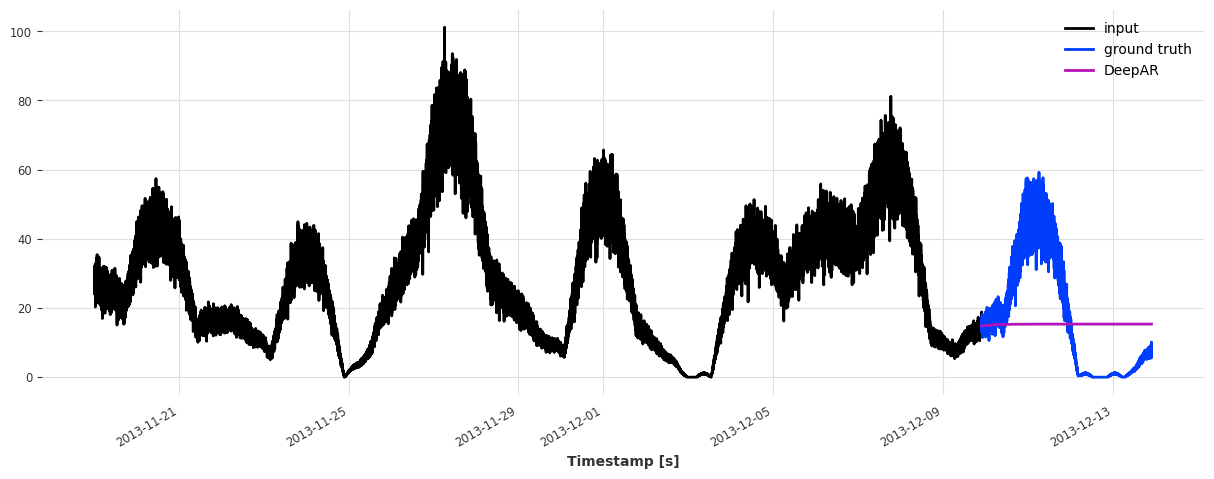

In [15]:
from darts.metrics import quantile_loss

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = common_model_args["output_chunk_length"] * 2
pred_input = test[:-pred_steps]

# Set the specific start date
start_date = pd.Timestamp("2013-12-11")
end_date = pd.Timestamp("2013-12-14")

fig, ax = plt.subplots(figsize=(15, 5))
# plt.xlim(start_date, end_date)

scaler.inverse_transform(pred_input).plot(label="input")
scaler.inverse_transform(test)[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets
for model_name, model in models.items():
    pred_series = model.predict(n=pred_steps, series=pred_input)
    scaler.inverse_transform(pred_series).plot(label=model_name, ax=ax)

    result_accumulator[model_name] = {
        "mae": mae(test, pred_series),
        "mse": mse(test, pred_series)
    }

In [22]:
# Load the saved model
loaded_model = NHiTSModel.load("models/NHiTS_bitbrains_cpu.pt")

Predicting: |                                                    | 0/? [00:00<?, ?it/s]

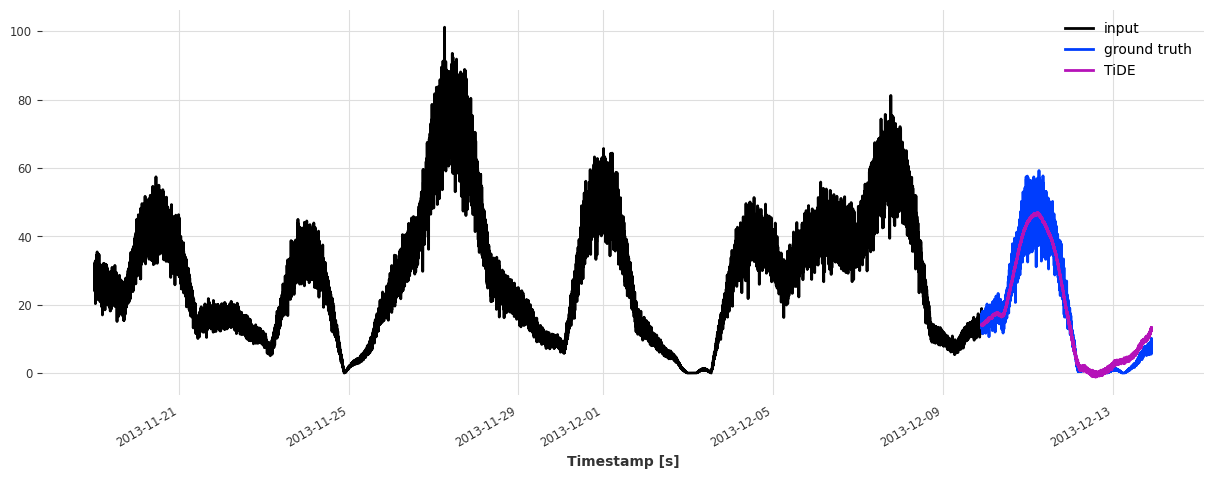

In [23]:
from darts.metrics import quantile_loss

# we will predict the next `pred_steps` points after the end of `pred_input`
pred_steps = 2880 * 2
pred_input = test[:-pred_steps]

# Set the specific start date
start_date = pd.Timestamp("2013-12-11")
end_date = pd.Timestamp("2013-12-14")

fig, ax = plt.subplots(figsize=(15, 5))
# plt.xlim(start_date, end_date)

scaler.inverse_transform(pred_input).plot(label="input")
scaler.inverse_transform(test)[-pred_steps:].plot(label="ground truth", ax=ax)

result_accumulator = {}
# predict with each model and compute/store the metrics against the test sets

pred_series = loaded_model.predict(n=pred_steps, series=pred_input)
scaler.inverse_transform(pred_series).plot(label=model_name, ax=ax)

result_accumulator["NHiTs"] = {
    "mae": mae(test, pred_series),
    "mse": mse(test, pred_series)
}

In [12]:
results_df = pd.DataFrame.from_dict(result_accumulator, orient="index")
results_df.head()

,mae,mse
TCN,0.071806,0.006882


In [13]:
pred_df = pred_series.pd_dataframe()

In [21]:
pred_df.head(-1)

component,CPU usage [%]
Timestamp [s],
2013-12-09 21:59:00,0.140837
2013-12-09 22:00:00,0.142607
2013-12-09 22:01:00,0.139660
2013-12-09 22:02:00,0.153624
2013-12-09 22:03:00,0.121751
...,...
2013-12-13 21:53:00,0.061563
2013-12-13 21:54:00,0.099427
2013-12-13 21:55:00,0.123423
